In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [3]:
genre_train = pd.read_csv("gdrive/MyDrive/genre_train_trimmed.csv", dtype='float16')

In [4]:
genre_train.fillna(0, inplace=True)

In [5]:
genre_train = genre_train.astype('int8')

In [6]:
others_train = pd.read_csv("gdrive/MyDrive/others_train_trimmed.csv")

In [7]:
others_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475484 entries, 0 to 1475483
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   msno                1475484 non-null  object 
 1   song_id             1475484 non-null  object 
 2   source_system_tab   1470482 non-null  object 
 3   source_screen_name  1392479 non-null  object 
 4   source_type         1471165 non-null  object 
 5   target              1475484 non-null  int64  
 6   song_length         1475464 non-null  float64
 7   artist_name         1475464 non-null  object 
 8   composer            1141030 non-null  object 
 9   lyricist            840135 non-null   object 
 10  language            1475456 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 123.8+ MB


In [8]:
s = others_train['artist_name']
labels, levels_artist = pd.factorize(s)
others_train['artist_name'] = pd.Series(labels)

In [9]:
s = others_train['song_id']
labels, levels_songs = pd.factorize(s)
others_train['song_id'] = pd.Series(labels)

In [10]:
s = others_train['msno']
labels, levels_msno = pd.factorize(s)
others_train['msno'] = pd.Series(labels)

In [11]:
del s

In [12]:
others_train['language'].fillna(0, inplace=True)

In [13]:
others_train['msno'] = others_train['msno'].astype('int32')
others_train['song_id'] = others_train['song_id'].astype('int32')
others_train['target'] = others_train['target'].astype('int8')
others_train['artist_name'] = others_train['artist_name'].astype('int32')
others_train['language'] = others_train['language'].astype('int16')

In [14]:
others_train.drop(columns=['song_length', 'composer','lyricist'], inplace=True)

In [15]:
others_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475484 entries, 0 to 1475483
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   msno                1475484 non-null  int32 
 1   song_id             1475484 non-null  int32 
 2   source_system_tab   1470482 non-null  object
 3   source_screen_name  1392479 non-null  object
 4   source_type         1471165 non-null  object
 5   target              1475484 non-null  int8  
 6   artist_name         1475484 non-null  int32 
 7   language            1475484 non-null  int16 
dtypes: int16(1), int32(3), int8(1), object(3)
memory usage: 54.9+ MB


In [16]:
others_train, others_test = train_test_split(others_train, test_size=0.2, shuffle=False)
genre_train, genre_test = train_test_split(genre_train, test_size=0.2, shuffle=False)

In [17]:
num_users = len(others_train.msno)
num_songs = len(others_train.song_id)
print(num_users, num_songs)

1180387 1180387


In [18]:
others_train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,language
0,0,0,my library,Local playlist more,local-library,1,0,-1
1,1,1,my library,Local playlist more,local-library,0,1,52
2,2,2,my library,Local playlist more,local-playlist,1,2,3
3,3,3,my library,Local playlist more,local-playlist,1,3,31
4,4,4,my library,Local playlist more,local-library,1,4,31


In [19]:
class NeuralNet(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=100):
        super(NeuralNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.song_emb = nn.Embedding(num_songs, emb_size)
        self.layer1 = nn.Linear(emb_size*2 + n_hidden+n_hidden - 6, n_hidden)
        self.layer2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.1)

    def forward(self, u, v, w, y):
        user = self.user_emb(u)
        song = self.song_emb(v)
        x = F.relu(torch.cat([user, song, w, y], dim=1))
        x = self.drop1(x)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [20]:
def train_epocs_hybrid(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(others_train.msno.values) # .cuda()
        songs = torch.LongTensor(others_train.song_id.values) #.cuda()
        genres = torch.LongTensor(genre_train.values) #.cuda()
        others = torch.LongTensor(others_train[['language', 'artist_name']].values)
        targets = torch.FloatTensor(others_train.target.values) #.cuda()
        if unsqueeze:
            targets = targets.unsqueeze(1)
        y_hat = model(users, songs, genres, others)
        loss = F.binary_cross_entropy_with_logits(y_hat, targets)
        train_loss.append((i, loss.item()))
        if (i+1) % 10 == 0:
          print("Iteration: %d ; error = %.4f" % (i+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    test_loss_hybrid(model, unsqueeze)

In [21]:
def test_loss_hybrid(model, unsqueeze=False):
    model.eval()
    users = torch.LongTensor(others_train.msno.values) # .cuda()
    songs = torch.LongTensor(others_train.song_id.values) #.cuda()
    genres = torch.LongTensor(genre_train.values) #.cuda()
    others = torch.LongTensor(others_train[['language', 'artist_name']].values)
    targets = torch.FloatTensor(others_train.target.values) #.cuda()
    if unsqueeze:
        targets = targets.unsqueeze(1)
    y_hat = model(users, songs, genres, others)
    loss = F.mse_loss(y_hat, targets)
    print("test loss %.3f " % loss.item())

In [22]:
model_hybrid_20 = NeuralNet(num_users, num_songs, emb_size=20)
model_hybrid_20

NeuralNet(
  (user_emb): Embedding(1180387, 20)
  (song_emb): Embedding(1180387, 20)
  (layer1): Linear(in_features=234, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=1, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
)

In [23]:
train_loss = []
train_epocs_hybrid(model_hybrid_20, epochs=20, lr=0.01, wd=1e-6, unsqueeze=True)

Iteration: 10 ; error = 5.5982
Iteration: 20 ; error = 3.0833
test loss 0.305 


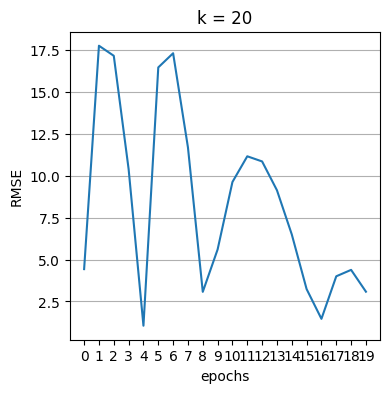

In [25]:
x = [x for x, y in train_loss]
y = [y for x, y in train_loss]
plt.figure(figsize=((4,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.title("k = 20")
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.grid(axis="y")